In [11]:
from util.trajectories import *
from util.guided_ot import *
from util.simplicial_paths import *
from util.alg_perf import dijkstra_tree

In [6]:
def get_proj_weights(SC, start, end, ref_path):
    def backtrace(prev, start, end):
        path, node = [], end
        while node != start:
            path.append(node)
            node = prev[node]
        path.append(node)
        path.reverse()
        return path
    
    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], extra=0)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj, ref_proj):
        proj_diff = np.linalg.norm(proj - ref_proj, 1)
        return np.round(proj_diff, 16)

    def cost(u, v, proj, ref_proj):
        next_proj = get_next_proj(u, v, proj)
        next_proj_diff = proj_cost(next_proj, ref_proj)
        potential_cost = next_proj_diff
        return potential_cost, next_proj
    
    def get_ref_proj(idx):
        if 0 <= idx < len(ref_path.path_edges):
            proj = ref_path.edge_projections[idx]
        elif idx < 0:
            proj = np.inf * np.ones(dim_proj)
        else:
            proj = ref_path.edge_projections[-1]
        return proj

    def init():
        prev = {}
        dist2src = {v:-1 for v in range(SC.node_vec.shape[0])}
        cost_dict = {v:np.inf for v in range(SC.node_vec.shape[0])}
        node_proj = {v:np.inf * np.ones(dim_proj) for v in range(SC.node_vec.shape[0])}

        visited = set()
        pq = pqdict()

        for i  in np.where(SC.node_vec == 1)[0]:
            pq[i] = float("inf") if (i != start) else 0

        dist2src[start] = 0 
        node_proj[start], cost_dict[start] = np.zeros(dim_proj), 0    

        return prev, dist2src, cost_dict, node_proj, visited, pq

    dim_proj = SC.H.shape[0]
    prev, dist2src, cost_dict, node_proj, visited, pq = init()
    node_children = {node:0 for node in np.where(SC.node_vec == 1)[0]}

    while len(pq) > 0:
        u = pq.pop()
        proj_u = node_proj[u]
        n_edges_u = dist2src[u]
        visited.add(u)
        n_edges_v = n_edges_u + 1        
        num_children = 0

        for v in SC.graph.neighbors(u): # v = neighbor of lowest cost node u
            if v in visited: # node must not have already been visited
                continue

            ref_proj = get_ref_proj(n_edges_v)
            new_cost, new_proj_v = cost(u, v, proj_u, ref_proj)
            old_cost = cost_dict[v]

            if new_cost < old_cost:
                if v in prev:
                    node_children[prev[v]] -= 1
                num_children += 1
                
                cost_dict[v] = new_cost
                prev[v] = u
                node_proj[v] = new_proj_v
                dist2src[v] = n_edges_v
                pq[v] = new_cost
            
        node_children[u] = num_children

    path = Trajectory(SC, backtrace(prev, start, end), extra=0)

    heads = [node for node in node_children if not node_children[node]]
    other_paths = [Trajectory(SC, backtrace(prev, start, head), extra=0) for head in heads]

    return path, other_paths

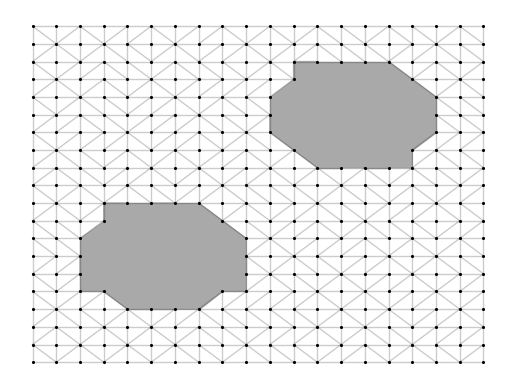

In [7]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

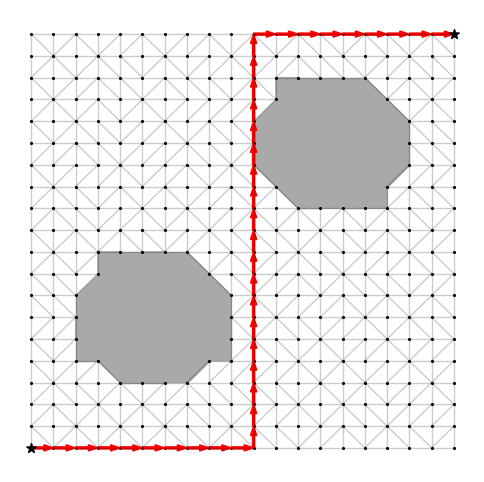

In [8]:
ref_path_coords = [(-1,-1), (0,-1), (0,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

In [9]:
path, other_paths = get_proj_weights(SC, start, end, ref_path)

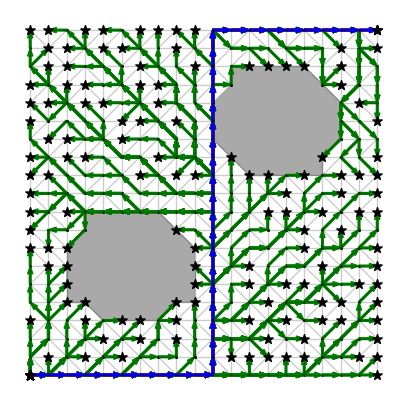

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8.30180939e-04  3.20859660e-01]
 [-1.87097569e-03  3.95654095e-01]
 [-3.68503954e-03  4.51274314e-01]
 [-6.27965196e-03  4.96249736e-01]
 [-1.11467078e-02  5.44977703e-01]
 [-1.79356120e-02  5.86889235e-01]
 [-2.52853440e-02  6.14219319e-01]
 [-3.03669912e-02  6.28214801e-01]
 [-3.58039062e-02  6.41003064e-01]
 [-4.09827190e-02  6.50746622e-01]
 [-4.49044624e-02  6.57329874e-01]
 [-4.86087356e-02  6.62801583e-01]
 [-4.95396324e-02  6.64101867e-01]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 3.50871134e-18  1.30851320e-02]
 [-3.60420479e-06  4.41265159e-02]
 [-1.34848268e-05  8.72893133e-02]
 [-5.86135985e-05  1.43302468e-01]
 [-1.52928188e-04  2.04924590e-01]
 [-4.03559914e-04  2.66442494e-01]
 [-8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


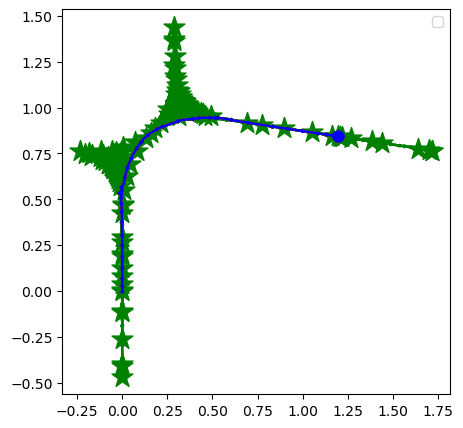

In [13]:
dijkstra_tree(SC, path, other_paths, ref_path_class, plot_others=True)